In [4]:
#Analysis the basic statistics of reply network
import pandas as pd
import numpy as np
import json
import networkx as nx
import networkx as nx
from datetime import datetime
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
def generate_network(nodes):
    """
    Generate a network graph from a list of nodes with 'id', 'in_reply_to_id', and metadata.

    :param nodes: List of dictionaries containing:
                  - 'id': Unique identifier for the post
                  - 'in_reply_to_id': ID of the parent post this replies to
                  - Metadata such as username, like counts, etc.
    :return: A NetworkX DiGraph with nodes and edges.
    """
    G = nx.DiGraph()  # Directed graph to represent reply relationships

    for node in tqdm(nodes):
        # Add the current node with metadata
        G.add_node(
            int(node['id']),
            # username=node['account']['username'],
            # display_name=node['account']['display_name'],
            # verified=node['account']['verified'],
            # followers_count=node['account']['followers_count'],
            # statuses_count=node['account']['statuses_count'],
            # replies_count=node['replies_count'],
            # favourites_count=node['favourites_count'],
            # reblogs_count=node['reblogs_count'],
            # visibility=node['visibility'],
            # content=node['content'],
            # created_at=node['created_at'],
            # language=node['language'],
            # sensitive=node['sensitive'],
            # mentions=[mention['username'] for mention in node.get('mentions', [])],
        )

        # If it replies to another node, add an edge
        if node['in_reply_to_id']:
            G.add_node(int(node['in_reply_to_id']))  # Add the parent node if it doesn't exist
            G.add_edge(int(node['in_reply_to_id']), int(node['id']) )

    return G


def build_network(graph, thread, parent_id=None):
    post = thread['post']
    post_id = post['uri']  # Use the URI as a unique identifier
    graph.add_node(post_id, text=post['record']['text'], author=post['author']['displayName'])
    
    if parent_id:  # If there is a parent, add an edge
        graph.add_edge(  parent_id, post_id)
    
    # Process replies recursively
    for reply in thread.get('replies', []):
        build_network(graph, reply, post_id)
with open('../data/bsky_threads.json') as f:
    bsky = json.load(f)
with open('../data/ts_threads.json') as f:
    ts = json.load(f)
bsky_network = nx.DiGraph()
error_count = 0
# Build the graph
for thread in tqdm(bsky):
    try:
        build_network(bsky_network, thread['thread'])
    except:
        error_count += 1


# Generate the network graph
ts_network = generate_network(ts)

  0%|          | 0/81805 [00:00<?, ?it/s]

  0%|          | 0/1369696 [00:00<?, ?it/s]

In [8]:
from statistics import mean
def calculate_cascade_statistics(graph):
    """
    Calculate cascade statistics for each tree (connected component) in a directed graph.


    Parameters:
        graph (nx.DiGraph): A directed graph representing the network.

    Returns:
        list: A list of dictionaries with cascade statistics for each tree.
    """
    if not isinstance(graph, nx.DiGraph):
        raise ValueError("The input graph must be a directed graph (DiGraph).")
    
    # Find all connected components (trees) in the directed graph
    components = list(nx.weakly_connected_components(graph))

    cascade_stats = []
    for i, component in enumerate(components):
        # Extract the subgraph for this component
        tree = graph.subgraph(component)
        
        # Calculate size
        size = len(tree.nodes)

        # Calculate depth
        roots = [node for node in tree.nodes if tree.in_degree(node) == 0]
        if len(roots) > 1:
            raise ValueError("Multiple roots found in the tree.")
        depth = 0
        if roots:
            for root in roots:
                depths = nx.single_source_shortest_path_length(tree, root).values()
                depth = max(depth, *depths)

        # Calculate maximum breadth
        breadth_levels = defaultdict(int)
        for node in tree.nodes:
            try:
                level = nx.shortest_path_length(tree, roots[0], node)
                breadth_levels[level] += 1
            except nx.NetworkXNoPath:
                continue  # Node is unreachable

        max_breadth = max(breadth_levels.values()) if breadth_levels else 0

        # Calculate structural virality
        if len(tree.nodes) > 1:
            shortest_paths = nx.shortest_path_length(tree)
            virality = mean(
                [mean(lengths.values()) for _, lengths in shortest_paths if lengths]
            )
        else:
            virality = 0  # Single node has no structural virality

        cascade_stats.append({
            "root_id": roots[0],
            "size": size,
            "depth": depth,
            "max_breadth": max_breadth,
            "structural_virality": virality,
        })

    return cascade_stats


In [9]:
bsky_stats = calculate_cascade_statistics(bsky_network)
ts_stats = calculate_cascade_statistics(ts_network)

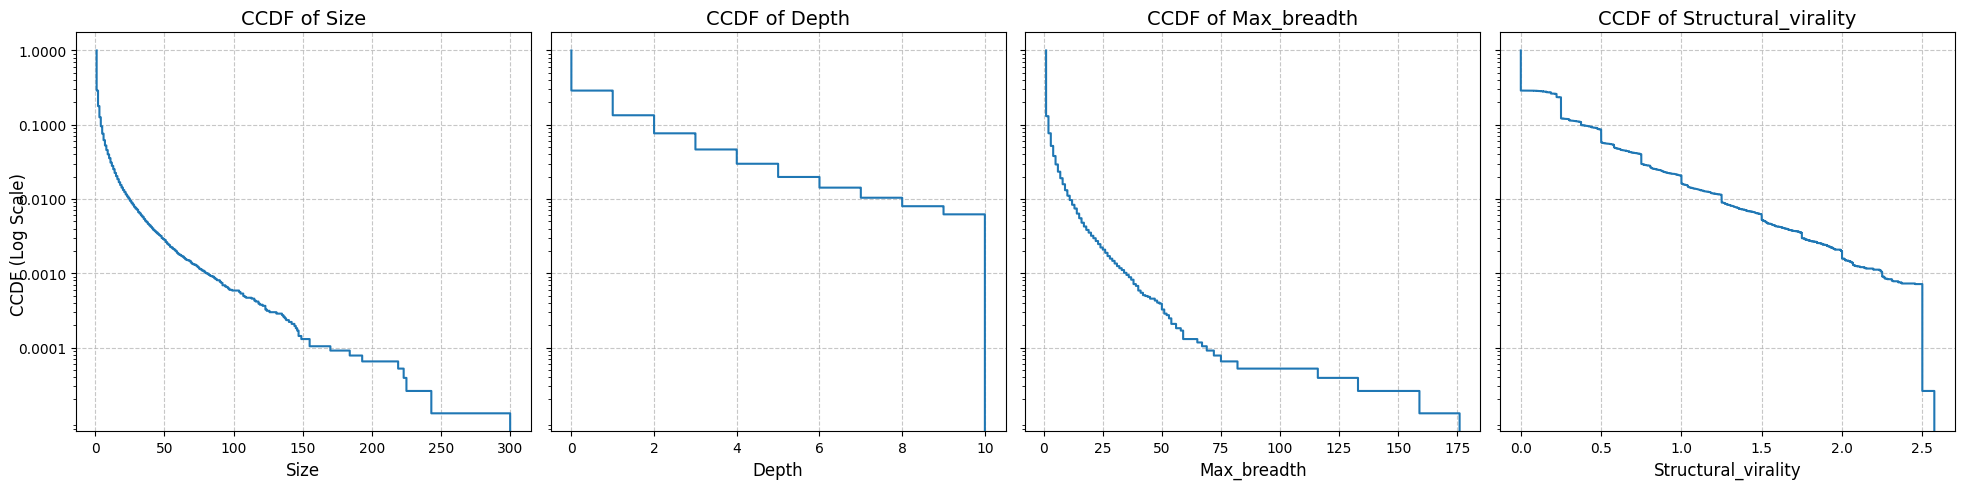

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_ccdfs(cascade_stats, stat_names):
    """
    Plot grouped CCDFs for multiple statistics in a single figure with a logarithmic y-axis.

    Parameters:
        cascade_stats (list): List of dictionaries containing cascade statistics.
        stat_names (list): List of keys for the statistics to plot (e.g., ['size', 'depth']).
    """
    # Create subplots
    n_stats = len(stat_names)
    fig, axes = plt.subplots(1, n_stats, figsize=(5 * n_stats, 5), sharey=True)

    for i, stat_name in enumerate(stat_names):
        # Extract the values for the specified statistic
        values = [stat[stat_name] for stat in cascade_stats]

        # Sort the values
        values = np.array(sorted(values))

        # Compute CCDF
        ccdf = 1 - np.arange(1, len(values) + 1) / len(values)

        # Plot CCDF
        ax = axes[i] if n_stats > 1 else axes
        ax.step(values, ccdf, where='post')
        ax.set_title(f"CCDF of {stat_name.capitalize()}", fontsize=14)
        ax.set_xlabel(stat_name.capitalize(), fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.7)

        # Set logarithmic y-axis
        ax.set_yscale('log')
        ax.set_yticks([1, 0.1, 0.01, 0.001, 0.0001,])
        ax.set_yticklabels(['100%', '10%', '1%', '0.1%', '0.01%'])
        ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
    
    # Set shared y-axis label
    fig.supylabel("CCDF (Log Scale)", fontsize=12)

    plt.tight_layout()
    plt.show()



plot_ccdfs(bsky_stats, ["size", "depth", "max_breadth", "structural_virality"])

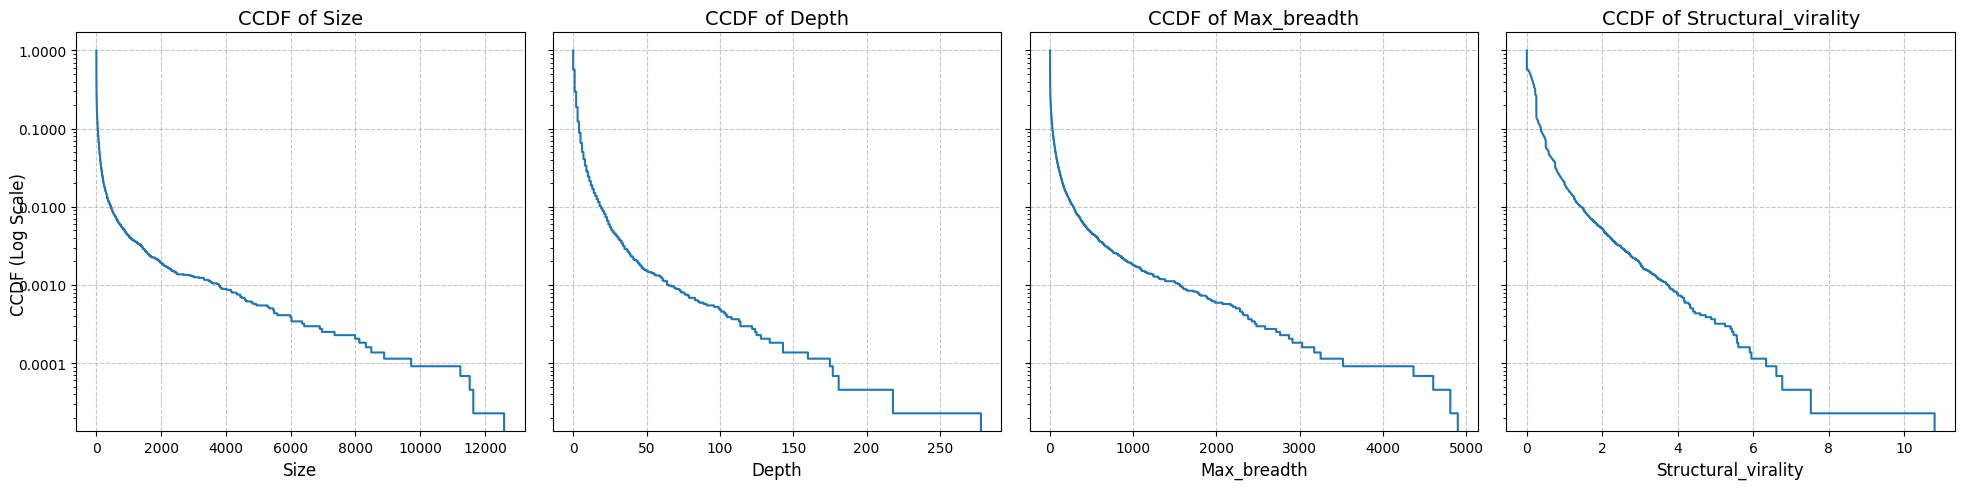

In [31]:
plot_ccdfs(ts_stats, ["size", "depth", "max_breadth", "structural_virality"])

In [34]:
#topics 
bsky_topics = pd.read_csv("../data/bsky_df_id_topic.csv")
ts_topics = pd.read_csv("../data/ts_df_id_topic.csv")

In [39]:
bsky_topics

,id,post,lang,topic,platform,topic_label
0,at://did:plc:pacn4jb5tkpf3dax35hauoqu/app.bsky...,So I know that the secret service is part of t...,en,7.0,bsky,Trump’s Tax Promises and Election Campaign
1,at://did:plc:5vzgjins5recitzoov4rby3y/app.bsky...,Laws are completely made up; they have always ...,en,6.0,bsky,Israel-Hamas Conflict and Biden’s Ceasefire Pr...
2,at://did:plc:4qqizocrnriintskkh6trnzv/app.bsky...,i am a centrist. i think trump should have to ...,en,7.0,bsky,Trump’s Tax Promises and Election Campaign
3,at://did:plc:wh6yelizss2c5kgsnasqcp4b/app.bsky...,I wanna know how many people looked up “Donald...,en,1.0,bsky,Trump’s Legal Convictions and Felony Charges
4,at://did:plc:zdhmhw4dmlwejq7x6sra23jo/app.bsky...,Trump is Guilty!\n\nCelebrate by donating to t...,en,1.0,bsky,Trump’s Legal Convictions and Felony Charges
...,...,...,...,...,...,...
81800,at://did:plc:7u2k45ynz63jnkquaebng5m2/app.bsky...,“Trump’s verdict speech fact-checked: what he ...,en,6.0,bsky,Israel-Hamas Conflict and Biden’s Ceasefire Pr...
81801,at://did:plc:7u4z3kd54eev2wevciavss23/app.bsky...,"This is, incidentally, why I think most of Tru...",en,7.0,bsky,Trump’s Tax Promises and Election Campaign
81802,at://did:plc:d2zt26jqooiwuezyzmjwyxoo/app.bsky...,last repost: that’s what makes Biden’s perform...,en,6.0,bsky,Israel-Hamas Conflict and Biden’s Ceasefire Pr...
81803,at://did:plc:4hm6gb7dzobynqrpypif3dck/app.bsky...,@cnnbrk: Jury deliberations have begun in Hunt...,en,4.0,bsky,"Hunter Biden’s Legal Troubles (e.g., Gun Charges)"


In [41]:
bsky_stats = pd.DataFrame(bsky_stats).merge(bsky_topics, left_on='root_id', right_on='id', how='left').drop(columns='id')
ts_stats = pd.DataFrame(ts_stats).merge(ts_topics, left_on='root_id', right_on='id', how='left').drop(columns='id')

In [42]:
ts_stats

,root_id,size,depth,max_breadth,structural_virality,post,topic,platform
0,112621599737106709,23,2,19,0.112476,Trump Trump Trump Trump Trump Trump Trump Trum...,Pro-Trump and MAGA Advocacy,ts
1,112632182054583684,495,10,334,0.197788,“Trump Campaign Announces ‘Black Americans for...,Biden vs. Trump Presidential Debates,ts
2,112616442650001570,397,11,338,0.118203,“Donald Trump Leading in Minnesota”,Trump’s Legal Convictions and Felony Charges,ts
3,112605503664527349,13,1,12,0.071006,Trump!,Trump’s Legal Convictions and Felony Charges,ts
4,112631948496888276,40,4,31,0.142500,"Trump, Donald Trump Shaken not stirred",Trump’s Legal Convictions and Felony Charges,ts
...,...,...,...,...,...,...,...,...
43813,112662952812123107,1,0,1,0.000000,Everything Trump touches dies. Including Chris...,Biden vs. Trump Presidential Debates,ts
43814,112686118077882132,3,2,1,0.500000,"I know it has been said many times before, but...",Israel-Hamas Conflict and Biden’s Ceasefire Pr...,ts
43815,112581278824456901,1,0,1,0.000000,Anyone who has any complaints about Trump need...,Biden vs. Trump Presidential Debates,ts
43816,112532468883570221,1,0,1,0.000000,MAGA IS ALREADY LEAVING TRUTH SOCIAL. PEOPLE A...,Pro-Trump and MAGA Advocacy,ts


In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Example function to calculate cascade size (can be extended for other stats)
def calculate_cascade_stats(df, group_col, stat_col):
    """
    Calculate cascade statistics (e.g., size) by grouping the dataframe.

    Parameters:
        df (pd.DataFrame): DataFrame with data.
        group_col (str): Column to group by (e.g., 'root_id').
        stat_col (str): Column to calculate the statistics on (e.g., 'id').

    Returns:
        pd.DataFrame: Cascade statistics with size and associated topic labels.
    """
    # Group by cascade root_id and calculate size
    grouped = df.groupby(group_col).agg({
        stat_col: 'count',  # Count posts in each cascade
        'topic_label': 'first'  # Keep the topic label
    }).reset_index()
    grouped.rename(columns={stat_col: 'size'}, inplace=True)
    return grouped

# Plot CCDFs grouped by topic
def plot_grouped_ccdfs(cascade_stats, stat_col, group_col):
    """
    Plot grouped CCDFs for a given statistic, grouped by topic labels.

    Parameters:
        cascade_stats (pd.DataFrame): DataFrame with cascade statistics.
        stat_col (str): The statistic column to compute the CCDF for (e.g., 'size').
        group_col (str): The column representing the group (e.g., 'topic_label').
    """
    unique_topics = cascade_stats[group_col].unique()
    plt.figure(figsize=(10, 6))
    
    for topic in unique_topics:
        # Filter data by topic
        topic_data = cascade_stats[cascade_stats[group_col] == topic]
        values = topic_data[stat_col].values

        # Compute CCDF
        values = np.sort(values)
        ccdf = 1 - np.arange(1, len(values) + 1) / len(values)

        # Plot CCDF
        plt.step(values, ccdf, where='post', label=topic)

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Cascade Size (Log Scale)', fontsize=12)
    plt.ylabel('CCDF (Log Scale)', fontsize=12)
    plt.title('CCDF by Topic', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title='Topic Label', fontsize=10)
    plt.tight_layout()
    plt.show()


# Example Usage
if __name__ == "__main__":
    # Load your DataFrame (example)
    data = bsky_stats   

    # Calculate cascade statistics
    cascade_stats = calculate_cascade_stats(data, group_col='topic_label', stat_col= "size")

    # Plot CCDFs grouped by topic
    plot_grouped_ccdfs(cascade_stats, stat_col='size', group_col='topic_label')


ValueError: cannot insert topic_label, already exists

/tmp/ipykernel_876569/457069331.py:31: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


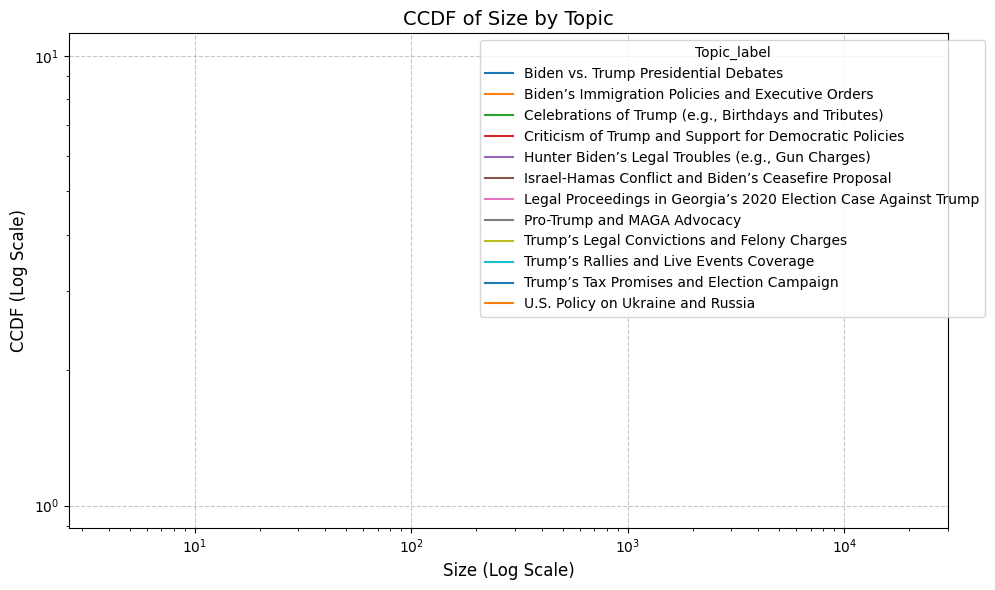

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_stats_by_topic(cascade_stats, stats_to_plot, topic_col):
    """
    Plot statistics grouped by topics using different colors.

    Parameters:
        cascade_stats (pd.DataFrame): DataFrame with cascade statistics and topics.
        stats_to_plot (list): List of statistic columns to plot (e.g., ['size', 'depth']).
        topic_col (str): Column representing topics (e.g., 'topic_label').
    """
    unique_topics = cascade_stats[topic_col].unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_topics)))

    plt.figure(figsize=(12, 8))

    for stat in stats_to_plot:
        plt.figure(figsize=(8, 6))
        for topic, color in zip(unique_topics, colors):
            topic_data = cascade_stats[cascade_stats[topic_col] == topic]
            values = topic_data[stat].values

            # Compute CCDF
            values = np.sort(values)
            ccdf = 1 - np.arange(1, len(values) + 1) / len(values)

            # Plot CCDF for the topic
            plt.step(values, ccdf, where='post', label=f'{topic}', color=color)

        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel(f'{stat.capitalize()} (Log Scale)', fontsize=12)
        plt.ylabel('CCDF (Log Scale)', fontsize=12)
        plt.title(f'CCDF of {stat.capitalize()} by Topic', fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(title='Topic', fontsize=10, bbox_to_anchor=(1.05, 1))
        plt.tight_layout()
        plt.show()



In [47]:
topic_stats

,topic_label,size
0,Biden vs. Trump Presidential Debates,17499
1,Biden’s Immigration Policies and Executive Orders,4298
2,"Celebrations of Trump (e.g., Birthdays and Tri...",1459
3,Criticism of Trump and Support for Democratic ...,4
4,"Hunter Biden’s Legal Troubles (e.g., Gun Charges)",6830
5,Israel-Hamas Conflict and Biden’s Ceasefire Pr...,9023
6,Legal Proceedings in Georgia’s 2020 Election C...,3100
7,Pro-Trump and MAGA Advocacy,1030
8,Trump’s Legal Convictions and Felony Charges,19750
9,Trump’s Rallies and Live Events Coverage,2340
